# Neural Network Projet
**Team members : Maelwenn Labidurie & Albane Coiffe**   
Groupe DAI

## Introduction

For this project, we chose to implement a deep convolutional neural network (Deep CNN) capable of detecting whether parking spots are occupied or free from camera images. Our main objective is to build a model that can be tested in real-world conditions, specifically, on the parking lot located just outside Maelwenn’s residence.

By using real-world footage, we aim to validate the robustness and practicality of our model beyond controlled datasets. This also opens the door to future applications in smart parking systems, where such a model could:

- Automatically monitor parking lots using video streams,

- Enable real-time reservation of available spots,

- Integrate into connected mobility or smart city platforms.



Below is an image showing the view of the parking lot as seen from Maelwenn’s window.



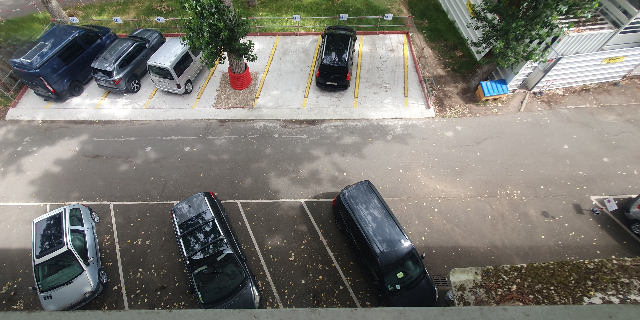

## Deep CNN
We chose an object detection approach in order to learn how to use YOLO to identify the status of parking spots.

Rather than classifying the entire image (e.g., as “full parking lot” or “empty parking lot”), our goal is for the model to detect each individual parking spot and determine whether it is occupied or free.

## Librairy installation

In [ ]:
import os
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
import random
import numpy as np
import math

In [ ]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

## Dataset - First test

At first, we intended to use the following public dataset: [link](https://public.roboflow.com/object-detection/pklot). 

This dataset contains images captured from parking lot surveillance cameras, with multiple parking spaces visible in each image.

Each image is associated with a .txt file located in the labels folder, containing annotations in the YOLOv5 format.

In the .txt files located under labels, each line corresponds to one detected object, with 5 values:

```bash
<class_id> <x_center> <y_center> <width> <height>
```

| Element    | Description                                           |
| ---------- | ----------------------------------------------------- |
| `class_id` | Class index (e.g., 0 = occupied, 1 = free)            |
| `x_center` | Center of the bounding box, X-axis (normalized value) |
| `y_center` | Center of the bounding box, Y-axis                    |
| `width`    | Width of the bounding box (normalized)                |
| `height`   | Height of the bounding box (normalized)               |


The name of the .txt file matches the name of its corresponding image file.

The goal is to train YOLOv5 on this dataset so that, given a new image, the model can:

Locate all visible parking spaces, and

Predict whether each one is free or occupied.



### Data process

In [ ]:
DATASET_DIR = "PKLot.v2-640.yolov5pytorch"
SPLITS = ["train", "valid", "test"]

In [ ]:
def check_correspondance():
    for split in SPLITS:
        img_dir = os.path.join(DATASET_DIR, split, "images")
        lbl_dir = os.path.join(DATASET_DIR, split, "labels")

        if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
            print(f"Dossier manquant dans {split}")
            continue

        img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(".jpg")}
        lbl_files = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith(".txt")}

        only_images = img_files - lbl_files
        only_labels = lbl_files - img_files

        print(f"\n🔍 Split : {split}")
        print(f" - Total images : {len(img_files)}")
        print(f" - Total labels : {len(lbl_files)}")
        if only_images:
            print(f"Images sans labels : {sorted(list(only_images))}")
        if only_labels:
            print(f"Labels sans images : {sorted(list(only_labels))}")
        if not only_images and not only_labels:
            print("Tout est cohérent.")
check_correspondance()

All the images are well assiociated with their label. It's perfect.

In [ ]:
def check_image_sizes(dataset_dir, split="train"):
    img_dir = os.path.join(dataset_dir, split, "images")
    size_counter = Counter()

    for fname in os.listdir(img_dir):
        if not fname.endswith(".jpg"):
            continue
        path = os.path.join(img_dir, fname)
        img = cv2.imread(path)
        if img is None:
            print(f"Impossible de lire l'image : {fname}")
            continue
        h, w = img.shape[:2]
        size_counter[(h, w)] += 1

    print(f"\nDimensions des images dans '{split}/images/' :")
    for size, count in size_counter.items():
        print(f" - {size[1]}x{size[0]} : {count} image(s)")

    if len(size_counter) == 1:
        print("Toutes les images ont la même taille.")
    else:
        print("Plusieurs tailles d'images détectées.")

check_image_sizes("PKLot.v2-640.yolov5pytorch", "train")
check_image_sizes("PKLot.v2-640.yolov5pytorch", "valid")
check_image_sizes("PKLot.v2-640.yolov5pytorch", "test")

All the images have the same size

In [ ]:
def check_normalized_labels(dataset_path):
    splits = ['train', 'valid', 'test']
    errors = []

    for split in splits:
        label_dir = os.path.join(dataset_path, split, 'labels')
        for fname in os.listdir(label_dir):
            if not fname.endswith('.txt'):
                continue

            fpath = os.path.join(label_dir, fname)
            with open(fpath, 'r') as f:
                lines = f.readlines()

            for i, line in enumerate(lines):
                parts = line.strip().split()
                if len(parts) != 5:
                    errors.append((split, fname, i, "Mauvais format"))
                    continue

                cls, x, y, w, h = parts
                try:
                    x, y, w, h = map(float, [x, y, w, h])
                    cls = int(cls)
                    if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                        errors.append((split, fname, i, f"Valeurs hors [0,1] : {x}, {y}, {w}, {h}"))
                except ValueError:
                    errors.append((split, fname, i, "Conversion impossible"))

    if not errors:
        print("Toutes les annotations sont bien normalisées.")
    else:
        print("Problèmes détectés :")
        for err in errors:
            print(f"[{err[0]}] {err[1]} (ligne {err[2]+1}) : {err[3]}")

check_normalized_labels("PKLot.v2-640.yolov5pytorch")

All the label's data are well normalized.

| features      | Normalized value |
| ---------- | ------------------------------------ |
| `x_center` | entre 0 et 1                         |
| `y_center` | entre 0 et 1                         |
| `width`    | entre 0 et 1                         |
| `height`   | entre 0 et 1                         |
| `class_id` | entier >= 0                          |


In [ ]:
def show_random_image_with_boxes(split="train"):
    img_dir = os.path.join(DATASET_DIR, split, "images")
    lbl_dir = os.path.join(DATASET_DIR, split, "labels")

    images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
    if not images:
        print("Aucune image trouvée.")
        return

    # Choisir une image au hasard
    img_name = random.choice(images)
    label_name = img_name.replace(".jpg", ".txt")

    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(lbl_dir, label_name)

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"⚠️ Pas de label pour l’image : {img_name}")
        return

    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(8, 6))
    plt.title(f"{img_name} avec bounding boxes")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    show_random_image_with_boxes("train") 

In [ ]:
import os
import shutil

def backup_clean_dataset(source_dir, dest_dir="../PKLot_cleaned"):
    if os.path.exists(dest_dir):
        print(f"The folder '{dest_dir}' already exists. Please choose another name or delete it.")
        return

    shutil.copytree(source_dir, dest_dir)
    print(f"Cleaned dataset copied to: {dest_dir}")

# Usage
backup_clean_dataset("PKLot.v2-640.yolov5pytorch")

## The model - First Test

### Dataset Configuration

To train our YOLOv5 model, we prepared a custom dataset configuration file called data.yaml. This file defines the path to our cleaned dataset and the structure expected by the training pipeline. Here's the content of our data.yaml file:

```py
path: ./PKLot_cleaned
train: train/images
val: valid/images
nc: 2
names:
  - empty
  - occupied
```
This means:
- The dataset is located in the PKLot_cleaned directory, one level above the project.
- Training images and labels are located in `PKLot_cleaned/train/images` and `PKLot_cleaned/train/labels`.
- Validation data is in `PKLot_cleaned/valid/images` and `valid/labels`.
- There are two classes: empty (free parking spot) & occupied (taken parking spot)

### Training Procedure

We used the following command to launch the training:

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov5nu.pt epochs=100 imgsz=640

We trained the model for 100 epochs with an input image size of 640x640 pixels.

This setup allows the model to learn how to localize and classify individual parking spots as either free or occupied.

### The result

Unfortunately, the results of our first training attempt were unsuccessful. After training the YOLOv5n model for 100 epochs, the model was unable to correctly detect or classify any parking spots in the validation or test images.

Despite following standard YOLOv5 training procedures and using a structured dataset, the model consistently returned no bounding boxes during inference, even when run on clearly annotated images.

We believe one of the main reasons for our model’s poor performance is the visual discrepancy between our training data and the target environment.


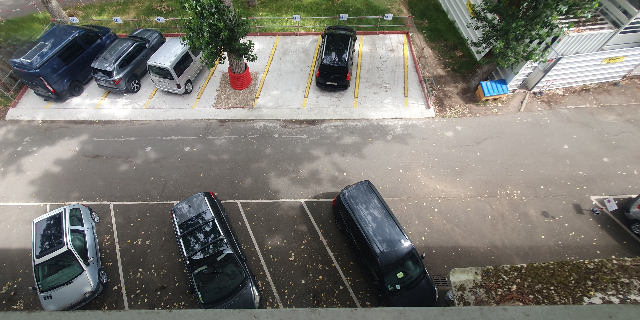
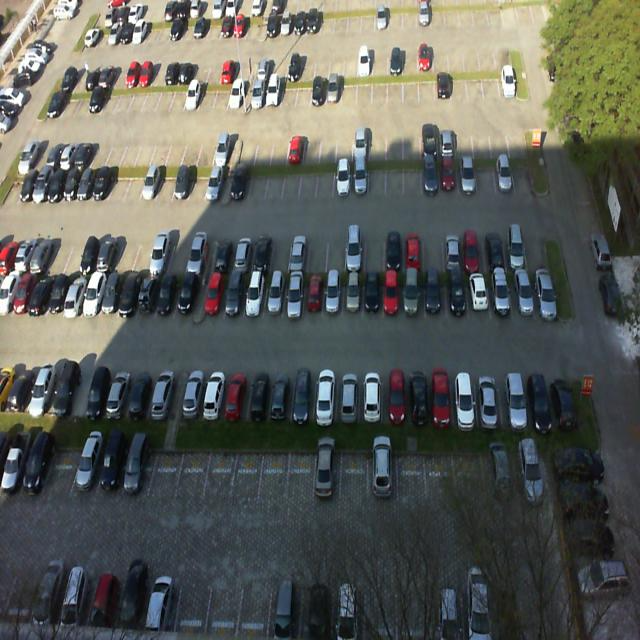

The **first image** represents the real parking lot we intended to use for testing — a small residential area with a low camera angle, partial occlusions, and varied lighting conditions.
The second image, on the other hand, is an example from the public dataset we used for training, which contains wide-angle views from elevated cameras, uniform lighting, and clearly separated parking lines.

This difference in camera angle, parking layout, background, and overall scene composition likely made it difficult for the model to generalize and correctly detect parking spots in our real-world images.

### Solution
To address this issue, we decided to look for another dataset that more closely resembles our real parking lot. Our goal was to find images with similar camera angles, parking layouts, and environmental conditions to improve the model’s ability to generalize.

We even considered using multiple datasets and merging them into a single training set to increase diversity and robustness. By combining data from different sources, we aim to train a more resilient and accurate model, capable of performing reliably in our real-world testing environment.



## Dataset - Second Test

### Downloading the first new dataset

We access the project named `parking-space-pubnz-ftfle` in the workspace `data-a09tr`.

We select version 1 of the dataset.

Then, we download it in YOLOv8 format, which creates a new folder locally (e.g., parking-space-pubnz-ftfle-1/).

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="8J41NUsg0Vpt63zevgPD")
project = rf.workspace("data-a09tr").project("parking-space-pubnz-ftfle")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to parking-space-1 in yolov8:: 100%|██████████| 3184/3184 [00:01<00:00, 2743.76it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Downloading the second dataset

Same process, but now for another dataset: `car-space-find-wozyb`.

In [ ]:
rf = Roboflow(api_key="8J41NUsg0Vpt63zevgPD")
project = rf.workspace("data-a09tr").project("car-space-find-wozyb")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-Space-Find-1 in yolov8:: 100%|██████████| 1212/1212 [00:00<00:00, 3365.53it/s]


### Downloading the third dataset
Again, same steps for a third dataset.

In [ ]:
rf = Roboflow(api_key="8J41NUsg0Vpt63zevgPD")
project = rf.workspace("data-a09tr").project("parking-space-ipm1b-dt0x2")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Parking-Space-1 in yolov8:: 100%|██████████| 6258/6258 [00:02<00:00, 2876.25it/s]


### Creating a base data.yaml manually

This YAML file tells YOLO:
- Where your dataset is located
- Where to find training and validation images
- That you have 2 classes: "empty" and "occupied"

In [ ]:
import yaml

data = {
    'path': '/content/drive/MyDrive/data_pk_quentin',
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 2,
    'names': ['empty', 'occupied']
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

### Function to merge datasets with suffixes

This function:
- Creates the full directory structure for train/, valid/, and test/ folders under the destination path.
- Copies all files from each source dataset into the appropriate folders.
- Appends a suffix to each copied filename (e.g., img001_ds1.jpg) to avoid name conflicts.
- Writes a new data.yaml file inside the destination folder.

In [ ]:
import shutil
from pathlib import Path
import yaml

def merge_yolo_datasets(source1, source2, source3, source4, destination):
    # Créer la structure finale
    for split in ['train', 'valid', 'test']:
        for sub in ['images', 'labels']:
            Path(f"{destination}/{split}/{sub}").mkdir(parents=True, exist_ok=True)

    def copy_with_suffix(src_path, dst_path, suffix):
        if src_path.exists():
            for file in src_path.iterdir():
                new_name = file.stem + suffix + file.suffix
                shutil.copy(file, dst_path / new_name)

    # Copier les fichiers des 4 sources
    for split in ['train', 'valid', 'test']:
        for sub in ['images', 'labels']:
            dst = Path(f"{destination}/{split}/{sub}")

            copy_with_suffix(Path(f"{source1}/{split}/{sub}"), dst, "_ds1")
            copy_with_suffix(Path(f"{source2}/{split}/{sub}"), dst, "_ds2")
            copy_with_suffix(Path(f"{source3}/{split}/{sub}"), dst, "_ds3")
            copy_with_suffix(Path(f"{source4}/{split}/{sub}"), dst, "_ds4")

    # Génération du fichier data.yaml
    data_yaml = {
        'path': destination,
        'train': 'train/images',
        'val': 'valid/images',
        'nc': 2,
        'names': ['empty', 'occupied']
    }

    with open(Path(destination) / 'data.yaml', 'w') as file:
        yaml.dump(data_yaml, file, default_flow_style=False)

# Utilisation
merge_yolo_datasets(
    source1="/content/Car-Space-Find-1",
    source2="/content/parking-space-1",
    source3="/content/Parking-Space-1",
    source4="/content/drive/MyDrive/data_pk_quentin",
    destination="/content/parking_multi"
)


This merges the four datasets into one combined dataset at /content/parking_multi.

Now, you can train your YOLOv5/YOLOv8 model using the new data.yaml inside parking_multi.

In [ ]:
from ultralytics import YOLO

# Load a base model (e.g., nano version)
model = YOLO("yolov8n.pt")


100%|██████████| 6.25M/6.25M [00:00<00:00, 459MB/s]


In [ ]:
# Train on your dataset
model.train(data="parking_multi/data.yaml", epochs=50, imgsz=640)

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=parking_multi/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

100%|██████████| 755k/755k [00:00<00:00, 93.4MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 379MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2889.6±769.7 MB/s, size: 244.5 KB)


train: Scanning /content/parking_multi/train/labels... 3995 images, 147 backgrounds, 0 corrupt: 100%|██████████| 3995/3995 [00:03<00:00, 1175.72it/s]

train: /content/parking_multi/train/images/4878f6ff__6f1ecdf8-20250623_192235_ds4.jpg: corrupt JPEG restored and saved
train: /content/parking_multi/train/images/9d1704a7__5325d1f4-20250623_191251_ds4.jpg: corrupt JPEG restored and saved
train: /content/parking_multi/train/images/b2dc4b08__9c412855-20250623_193330_ds4.jpg: corrupt JPEG restored and saved
train: New cache created: /content/parking_multi/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 37175, len(boxes) = 65124. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 891.5±652.8 MB/s, size: 99.5 KB)


val: Scanning /content/parking_multi/valid/labels... 1004 images, 30 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:01<00:00, 815.92it/s]


val: New cache created: /content/parking_multi/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10394, len(boxes) = 16978. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.45G      1.307      1.351      1.227        339        640: 100%|██████████| 250/250 [00:31<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


                   all       1004      16978      0.879      0.804      0.889      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.47G     0.9495     0.7644      1.061        309        640: 100%|██████████| 250/250 [00:28<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.27it/s]


                   all       1004      16978      0.917      0.839      0.924      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.49G     0.8888     0.6841       1.03        487        640: 100%|██████████| 250/250 [00:28<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.31it/s]


                   all       1004      16978      0.917      0.879      0.939      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.51G     0.8318     0.6261      1.019        320        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


                   all       1004      16978      0.898       0.88      0.935      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.95G     0.8038     0.5795      1.005        351        640: 100%|██████████| 250/250 [00:27<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]

                   all       1004      16978      0.921      0.903      0.954      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.39G     0.7636     0.5504     0.9943        428        640: 100%|██████████| 250/250 [00:27<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]

                   all       1004      16978      0.926      0.903      0.952      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.41G     0.7508     0.5303     0.9883        201        640: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all       1004      16978      0.929      0.925      0.961      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.42G     0.7574      0.525       0.99        184        640: 100%|██████████| 250/250 [00:27<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]

                   all       1004      16978      0.912      0.901      0.954      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.9G     0.7333     0.5104     0.9865        440        640: 100%|██████████| 250/250 [00:27<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all       1004      16978       0.93      0.912      0.961        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.92G     0.7009     0.4817     0.9701        330        640: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]

                   all       1004      16978      0.921      0.932      0.965      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.94G     0.6801      0.472     0.9646        307        640: 100%|██████████| 250/250 [00:27<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]

                   all       1004      16978       0.93      0.918      0.959      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.95G     0.6689     0.4584     0.9622        542        640: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all       1004      16978      0.928      0.933      0.965      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.97G     0.6676     0.4582     0.9629        350        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all       1004      16978      0.937      0.923      0.966      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.99G     0.6789     0.4561     0.9626        388        640: 100%|██████████| 250/250 [00:27<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

                   all       1004      16978      0.932      0.931      0.967      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.52G     0.6801     0.4553     0.9661        265        640: 100%|██████████| 250/250 [00:27<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

                   all       1004      16978      0.932      0.933      0.966      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.53G     0.6426     0.4294     0.9549        169        640: 100%|██████████| 250/250 [00:27<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all       1004      16978      0.945      0.929      0.968       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.55G     0.6363     0.4237     0.9509        290        640: 100%|██████████| 250/250 [00:27<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

                   all       1004      16978      0.942      0.932       0.97      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.57G     0.6419     0.4193     0.9522        284        640: 100%|██████████| 250/250 [00:27<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]

                   all       1004      16978      0.944      0.943      0.972      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.59G     0.6378     0.4202     0.9489        362        640: 100%|██████████| 250/250 [00:27<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

                   all       1004      16978      0.938      0.931      0.971      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.6G     0.6299     0.4129     0.9496        216        640: 100%|██████████| 250/250 [00:27<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]

                   all       1004      16978      0.938       0.93      0.969      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.62G     0.6056     0.4015     0.9369        389        640: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]

                   all       1004      16978      0.948      0.934       0.97      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.64G     0.6067     0.4009      0.941        420        640: 100%|██████████| 250/250 [00:27<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

                   all       1004      16978      0.946      0.937      0.971      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.65G     0.6088      0.403      0.937        488        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]

                   all       1004      16978      0.942      0.943      0.971      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.67G     0.6108     0.4018     0.9448        172        640: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]

                   all       1004      16978      0.947      0.939      0.972      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.69G     0.6025     0.3965     0.9377        435        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

                   all       1004      16978      0.952      0.943      0.976      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.71G     0.5846     0.3874     0.9317        221        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

                   all       1004      16978      0.951      0.938      0.973      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.72G     0.5983     0.3909     0.9356        318        640: 100%|██████████| 250/250 [00:27<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

                   all       1004      16978      0.943      0.939      0.973      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.74G     0.5696     0.3734     0.9281        279        640: 100%|██████████| 250/250 [00:27<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

                   all       1004      16978      0.953      0.944      0.974      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.76G     0.5743     0.3761     0.9262        415        640: 100%|██████████| 250/250 [00:27<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all       1004      16978      0.954       0.94      0.974      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.77G     0.5715     0.3805     0.9265        733        640: 100%|██████████| 250/250 [00:27<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

                   all       1004      16978      0.952      0.943      0.975      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.79G     0.5681     0.3776     0.9219        240        640: 100%|██████████| 250/250 [00:27<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]

                   all       1004      16978      0.949      0.936      0.976      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.81G     0.5683     0.3826     0.9265        257        640: 100%|██████████| 250/250 [00:27<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

                   all       1004      16978      0.951      0.936      0.974      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.82G     0.5708      0.381      0.926        328        640: 100%|██████████| 250/250 [00:27<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

                   all       1004      16978      0.952      0.943      0.976      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.84G     0.5685     0.3805     0.9224        329        640: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]

                   all       1004      16978      0.953      0.944      0.977      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.86G      0.568     0.3859     0.9199        488        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

                   all       1004      16978      0.947      0.948      0.975      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.88G     0.5446     0.3636     0.9138        505        640: 100%|██████████| 250/250 [00:27<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.14it/s]

                   all       1004      16978      0.945      0.946      0.976      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.89G     0.5456     0.3689     0.9128        397        640: 100%|██████████| 250/250 [00:27<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

                   all       1004      16978      0.934      0.938      0.974       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.91G     0.5288      0.363     0.9074        350        640: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

                   all       1004      16978      0.943       0.94      0.975      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.93G     0.5396      0.369     0.9124        517        640: 100%|██████████| 250/250 [00:27<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

                   all       1004      16978      0.945      0.937      0.976      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.94G     0.5316     0.3606     0.9067        421        640: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

                   all       1004      16978      0.949      0.942      0.976      0.867


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.96G     0.5461     0.3542      0.914        206        640: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all       1004      16978      0.951       0.94      0.976      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.98G      0.536     0.3448     0.9106        264        640: 100%|██████████| 250/250 [00:25<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all       1004      16978      0.962      0.946      0.978      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         6G     0.5262     0.3413      0.909        119        640: 100%|██████████| 250/250 [00:25<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all       1004      16978      0.953      0.944      0.976      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.01G     0.5171     0.3352     0.8988        173        640: 100%|██████████| 250/250 [00:25<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

                   all       1004      16978      0.952       0.94      0.977      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.03G     0.5058     0.3289     0.8987        163        640: 100%|██████████| 250/250 [00:25<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

                   all       1004      16978      0.955      0.941      0.977      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.04G     0.5066     0.3245     0.8966        150        640: 100%|██████████| 250/250 [00:25<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]

                   all       1004      16978      0.958      0.943      0.978      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.06G     0.4978     0.3206     0.8937        174        640: 100%|██████████| 250/250 [00:25<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]

                   all       1004      16978      0.954      0.945      0.979      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.08G     0.4932     0.3218     0.8908        199        640: 100%|██████████| 250/250 [00:25<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all       1004      16978      0.951      0.948      0.977      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       6.1G     0.4774      0.313     0.8827        202        640: 100%|██████████| 250/250 [00:25<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

                   all       1004      16978      0.955      0.943      0.978      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.11G     0.4749     0.3137     0.8826        182        640: 100%|██████████| 250/250 [00:25<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]

                   all       1004      16978       0.96      0.946      0.979      0.879



50 epochs completed in 0.447 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


                   all       1004      16978       0.96      0.946      0.979      0.879
                 empty        916       5957      0.945      0.931      0.973      0.827
              occupied        884      11021      0.976      0.962      0.985      0.931
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7d9a79ac50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
!mkdir /content/models
!cp /content/runs/detect/train/weights/best.pt /content/models/model.pt
!cp -r /content/runs/detect/train /content/models

# Zip into "my_model.zip"
%cd models
!zip /content/models.zip model.pt
!zip -r /content/models.zip train
%cd /content

mkdir: cannot create directory ‘/content/models’: File exists
/content/models
  adding: model.pt (deflated 9%)
  adding: train/ (stored 0%)
  adding: train/labels_correlogram.jpg (deflated 32%)
  adding: train/val_batch2_labels.jpg (deflated 5%)
  adding: train/val_batch2_pred.jpg (deflated 4%)
  adding: train/train_batch2.jpg (deflated 3%)
  adding: train/train_batch10001.jpg (deflated 8%)
  adding: train/val_batch0_pred.jpg (deflated 4%)
  adding: train/confusion_matrix_normalized.png (deflated 30%)
  adding: train/val_batch1_labels.jpg (deflated 3%)
  adding: train/train_batch1.jpg (deflated 4%)
  adding: train/R_curve.png (deflated 13%)
  adding: train/labels.jpg (deflated 29%)
  adding: train/train_batch0.jpg (deflated 3%)
  adding: train/results.png (deflated 8%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (deflated 9%)
  adding: train/weights/best.pt (deflated 9%)
  adding: train/val_batch0_labels.jpg (deflated 4%)
  adding: train/confusion_matrix.png (d

In [ ]:
from google.colab import files

files.download('/content/models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>